# Jurasic Park Simulation

## Configuraciones globales

In [10]:
%pip install matplotlib numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [23]:
import json
import numpy as np
import matplotlib.pyplot as plt

from app.models.dinosaurios import *
from app.models.entorno import Entorno
from app.utils.draw_map import dibujar_mapa
from app.utils.batch_simulate import batch_simulate
from app.utils.genetic_algorithm import GeneticAlgorithm

Cargamos el mapa por defecto para realizar nuestras simulaciones y dibujemoslo en pantalla.

In [3]:
with open('app/data/mapa.json', 'r') as file:
    mapa_data = json.load(file)

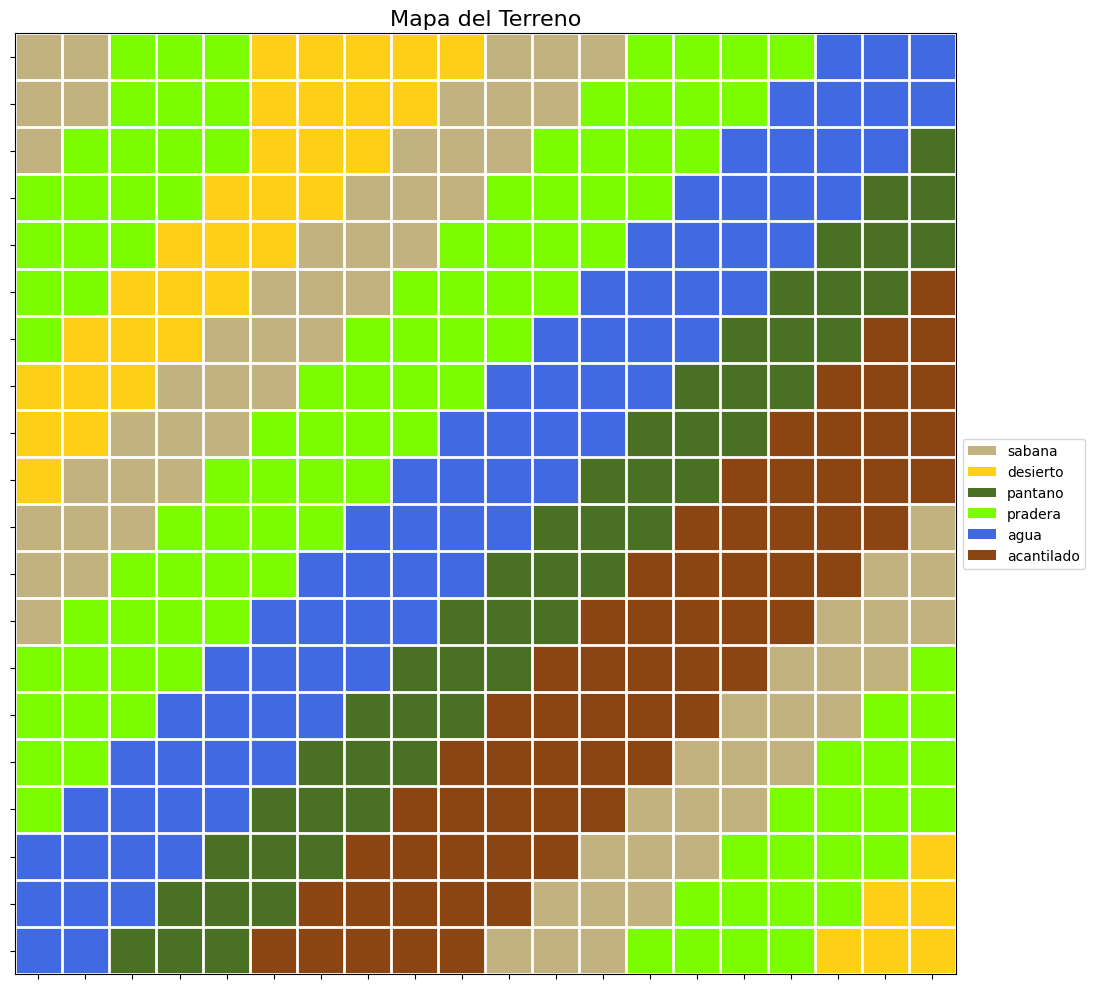

In [22]:
dibujar_mapa(mapa_data)

### Generar mapa utilizando mistral

#### [NOTA]
> Solo ejecute ésta sección si desea utilizar un nuevo mapa en vez del mapa por defecto.

### **Instalación**

In [ ]:
%pip install python-dotenv mistralai

In [ ]:
from dotenv import load_dotenv
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage
import os

from app.models.entorno import TERRENO_TIPOS

# Carga las variables de entorno desde el archivo .env
load_dotenv()

# Obtiene la API key de Mistral desde las variables de entorno
API_KEY = os.getenv("MISTRAL_API_KEY")

def get_mistral_response():
    # Prepara el mensaje a enviar basado en el input del usuario
    msg = f"Genera un mapa en formato json de 20 casillas de alto y 20 casillas de largo, \
    cada casilla puede ser de uno de los tipos ({TERRENO_TIPOS}),
    el json tendrá 2 valores (tamanio y terreno),
    devuelva únicamente el código del archivo json, tome como ejemplo el contenido del json siguiente: \
    ```python \
    {mapa_data}
    ``` "
    
    # Inicializa la lista de mensajes con el mensaje construido
    messages = [ChatMessage(role="user", content=msg)]
    
    # Crea una instancia del cliente de Mistral
    llm_client = MistralClient(api_key=API_KEY)
    
    # Inicializa la cadena de respuesta
    response = ""
    
    # Realiza la petición a Mistral y acumula las respuestas
    for chunk in llm_client.chat_stream(messages, model="mistral-small"):
        response += chunk.choices[0].delta.content

    return response


mapa_data = get_mistral_response()

## Hipótesis 1: La genética y las habilidades afectan significativamente la supervivencia

In [13]:
def batch_simulate_genotipos(n_simulaciones, dinosaurios=[], reproduccion=True):
    resultados_batch = []

    # Diferentes configuraciones de genotipos para evaluar
    genotipos_config = [
        {'fuerza': 80, 'inteligencia': 50, 'resistencia': 60},  # Humanos fuertes
        {'fuerza': 50, 'inteligencia': 90, 'resistencia': 70},  # Humanos inteligentes
        {'fuerza': 70, 'inteligencia': 70, 'resistencia': 70},  # Humanos balanceados
        {'fuerza': 30, 'inteligencia': 40, 'resistencia': 90},  # Humanos resistentes
    ]

    entorno = Entorno(mapa_data['tamanio'], np.matrix(mapa_data['terreno']))

    for genotipo in genotipos_config:
        poblacion_final = []

        results = batch_simulate(
            n_simulations=n_simulaciones,
            genotipo=genotipo,
            dinosaurios=dinosaurios,
            reproduccion=reproduccion,
            entorno=entorno
        )

        for i, result in enumerate(results):
            poblacion_final.append(result['poblacion'][-1])  # Población al final de la simulación

        # Guardar los resultados de cada configuración de genotipo
        resultados_batch.append({
            'genotipo': genotipo,
            'poblacion': result['poblacion'],
            'results': results,
            'poblacion_final': np.mean(poblacion_final)
        })

    return resultados_batch


In [14]:
def visualizar_resultados_batch(resultados_batch):
    # Extraer la información para graficar
    genotipos = ["Humanos fuertes", "Humanos inteligentes", "Humanos balanceados", "Humanos resistentes"]
    poblacion_final = [r['poblacion_final'] for r in resultados_batch]

    # Crear gráfico de barras para visualizar la hipótesis
    plt.figure(figsize=(10, 6))
    plt.bar(genotipos, poblacion_final)
    plt.title('Efecto de Genotipos en la Supervivencia')
    plt.xlabel('Genotipo (Fuerza, Inteligencia, Resistencia)')
    plt.ylabel('Población Final Promedio')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


Hagamos una primera simulacion sin dinosaurios y veamos los resultados.

In [15]:
# Ejecutar simulacion sin dinosaurios
resultados_batch = batch_simulate_genotipos(
    n_simulaciones=50,
)

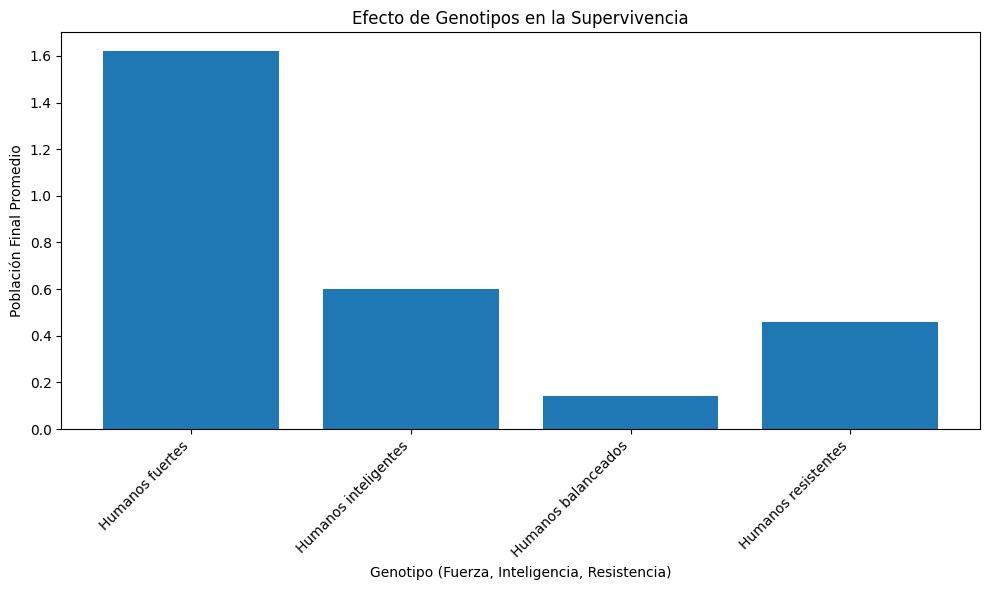

In [16]:
# Visualizar los resultados
visualizar_resultados_batch(resultados_batch)

Ahora hagamos una simulación agregando los dinosaurios al ecosistema

In [20]:
# Ejecutar simulaciones con dinosaurios
resultados_batch_dinosaurios = batch_simulate_genotipos(
    n_simulaciones=50,
    dinosaurios=[
        Braquiosaurio, Triceratops, Pteranodonte, Velociraptor, TiranosaurioRex
    ]
)

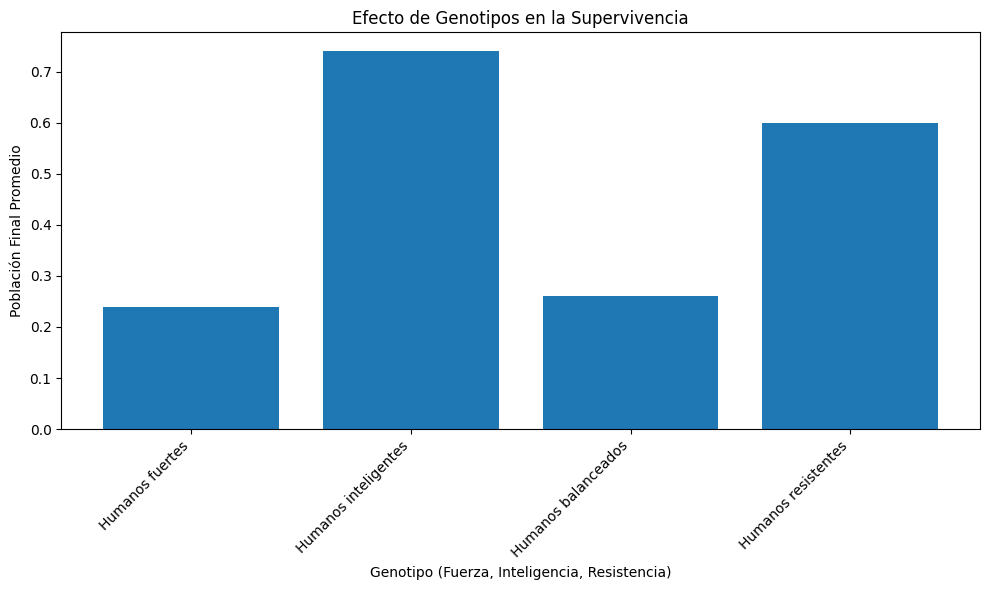

In [21]:
visualizar_resultados_batch(resultados_batch_dinosaurios)

## Hipótesis: La adaptabilidad mejora la capacidad de supervivencia en entornos cambiantes

In [22]:
def evaluar_hipotesis_adaptabilidad(n_simulaciones, dinosaurios=[], reproduccion=True):

    entorno = Entorno(mapa_data['tamanio'], np.matrix(mapa_data['terreno']))

    # Simulamos tres escenarios con diferentes niveles de adaptabilidad
    resultados_baja = batch_simulate(
        n_simulations=n_simulaciones,
        genotipo={'adaptabilidad': 20},
        dinosaurios=dinosaurios,
        reproduccion=reproduccion,
        entorno=entorno
    )
    resultados_media = batch_simulate(
        n_simulations=n_simulaciones,
        genotipo={'adaptabilidad': 50},
        dinosaurios=dinosaurios,
        reproduccion=reproduccion,
        entorno=entorno
    )
    resultados_alta = batch_simulate(
        n_simulations=n_simulaciones,
        genotipo={'adaptabilidad': 80},
        dinosaurios=dinosaurios,
        reproduccion=reproduccion,
        entorno=entorno
    )

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    for r in resultados_baja:
        plt.plot(r['poblacion'], label='Adaptabilidad Baja', color='r')

    for r in resultados_media:
        plt.plot(r['poblacion'], label='Adaptabilidad Media', color='g')

    for r in resultados_alta:
        plt.plot(r['poblacion'], label='Adaptabilidad Alta', color='b')

    plt.title('Supervivencia vs Ciclos con Diferentes Niveles de Adaptabilidad')
    plt.xlabel('Ciclos')
    plt.ylabel('Población')
    plt.legend()
    plt.grid(True)
    plt.show()


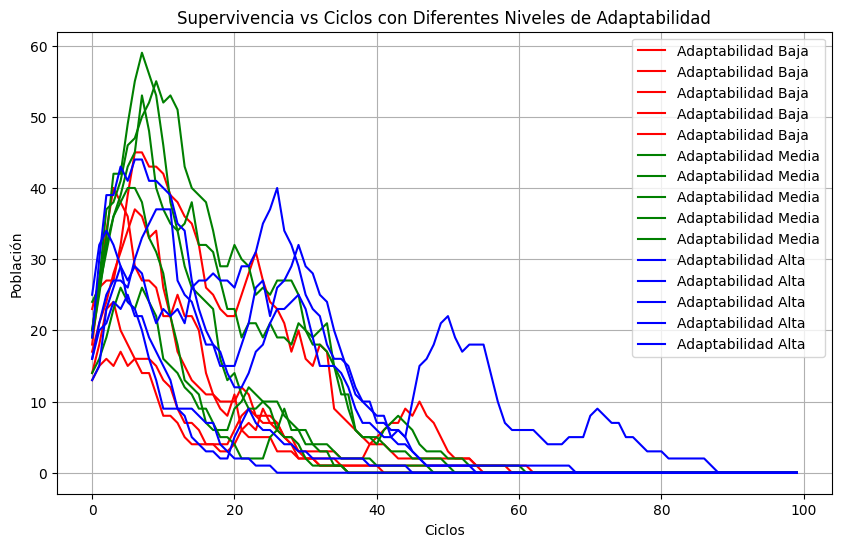

In [24]:
evaluar_hipotesis_adaptabilidad(
    n_simulaciones=5,
    dinosaurios=[
        Braquiosaurio, Triceratops, Pteranodonte, Velociraptor, TiranosaurioRex
    ]
)

## Algoritmo Genético

In [11]:
entorno = Entorno(mapa_data['tamanio'], np.matrix(mapa_data['terreno']))

genetic_algorithm = GeneticAlgorithm(
    dinosaurios=[
        Braquiosaurio, Triceratops, Pteranodonte, Velociraptor, TiranosaurioRex
    ],
    entorno=entorno
)

In [16]:
genetic_algorithm.evolucionar()
genetic_algorithm.seleccion()

In [19]:
print(genetic_algorithm.poblacion[0].genotipo)

{'fuerza': 61, 'velocidad': 49, 'resistencia': 22, 'inteligencia': 66, 'adaptabilidad': 68, 'supervivencia': 29}
